In [1]:
path='G:/Shared drives/BeStarsMiMeS/UpdatedFiles/' #Patrick's google file stream path

import LSDpy.lsdpy
import specpolFlow as pol


import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import itertools

import pyRaven as rav

In [2]:
#Accessing the google sheets

sheet_id = '1M6y1Wnsrc-w5FjUMfKaSFa_-foIDAaMe8W4lYNWnWyk'
sheet_name = 'Stars'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
StarData=pd.read_csv(url)

sheet_name = 'Observations'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Observations=pd.read_csv(url)

In [3]:
def read_disk(file):
  '''
  Read a synthetic spectrum from a s3div output

  :param file: The filename
  :rtype: wave, flux -- the wavelength in nm, and the normalized flux. 
  '''
  with open(file) as f:
    lines = f.readlines()
  # number of atomic lines in the header of the file
  natomic = int(lines[0].split(sep='-')[0])
  nwave=int(lines[natomic+1].split()[0])
  data = np.genfromtxt(lines[natomic+2:natomic+1+nwave])
  return(data[:,0]/10.0, data[:,1])

def split_order(data):
  '''
  Split an observation object into a list of observation objects with one order per item
  '''
  # one order is where the wavelength backtracks. 
  ind = np.where((data.wl[1:]-data.wl[0:-1]) < 0)[0]
  norder = ind.size+1
  ind = np.append(-1,ind)
  ind = np.append(ind,data.wl.size)
  print('{} orders'.format(norder))

  list_order=[]
  for i in range(0,norder):
    list_order.append(data[ind[i]+1:ind[i+1]])
 
  return(list_order)
  
def splice_order(list_order):
  '''
  Concatenate a list of observation objects (usually split into a list of orders by split_order function). Note: it does not merge the orders overlaps.
  '''
  wl = np.array([])
  specI = np.array([])
  specV = np.array([])
  specN1 = np.array([])
  specN2 = np.array([])
  specSig = np.array([])
  for item in list_order:
    wl=np.append(wl,item.wl)
    specI=np.append(specI,item.specI)
    specV=np.append(specV,item.specV)
    specN1=np.append(specN1,item.specN1)
    specN2=np.append(specN2,item.specN2)
    specSig=np.append(specSig, item.specSig)
  return(pol.Spectrum(wl, specI, specV, specN1, specN2, specSig, header=list_order[0].header))

def rshift(wave, radvel):
  '''
  Shift a spectrum in terms of radial velocity. The wavelength array and the velocity arrays must be defied as astropy units quantities.
  The new wavelength array is returned in the same units as the initial wavelength array. 
  '''
  return( (wave + wave*radvel/const.c).to(wave.unit).value )


## HD 7636

In [30]:
star='hd7636'
vsini=170
ModelCode='T18000G40'
vradCorrected=-30 *u.km/u.s

In [31]:
import copy
# reading the observed spectrum
file_obs = '{}00-InputMaterial/NormalizedSpectra/{}_{}.s'.format(path,star, 1)
data_obs = pol.read_spectrum(file_obs)
# splitting the observed spectrum by order
list_order = split_order(data_obs)


file_mod = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}.dsk'.format(path,star,ModelCode,vsini)
mod_wave, mod_flux = read_disk(file_mod)
# shifting the model spectrum for its radial velocity
# (note the rshift function asks for numpy unit quantities)

mod_wave_shift = rshift(mod_wave*u.nm, vradCorrected)

for order in list_order:

  # interpolate the shifted model onto the order grid
  mod_flux_interp = np.interp(order.wl, mod_wave_shift, mod_flux)

  # drawing n random elements with a mean of zero and a stdev of 1.0
  # scaling to a sigma corresponding to the error bar
  noise = np.random.standard_normal(order.wl.size)*order.specSig
  mod_flux_interp = mod_flux_interp + noise
  # replacing the flux array in the order
  order.specI = copy.deepcopy(mod_flux_interp)

# putting the orders back together
new = splice_order(list_order)

### writting back the file in the proper folder. 
## need to look for a write function for .s, maybe in Colin's 
## normalization code?

new.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}.s'.format(path,star,star,ModelCode,vsini))

37 orders


### All

In [32]:
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)
#mask.iuse[np.where([mask.element==14.01,mask.element==14.02,mask.element==14.03,mask.element==16.01,mask.element==16.02])[1]]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}.mask'.format(path,star,ModelCode,vsini))



In [33]:
file_mask='{}02-Mask-calculations/MaskCleaning/AsifMaskSuperClean_tellClean/{}_clean_{}.mask'.format(path,star,1)
mask = pol.read_mask(fname=file_mask)
#mask.iuse[np.where([mask.element==14.01,mask.element==14.02,mask.element==14.03,mask.element==16.01,mask.element==16.02])[1]]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated.mask'.format(path,star,star))




In [34]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

synthfile = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}.s'.format(path,star,star,ModelCode,vsini)
synth = pol.read_spectrum(synthfile)

fullfile_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}.mask'.format(path,star,ModelCode,vsini)
mask = pol.read_mask(fname=fullfile_mask)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated.mask'.format(path,star,star)
mask = pol.read_mask(fname=file_mask)



(0.8, 1.05)

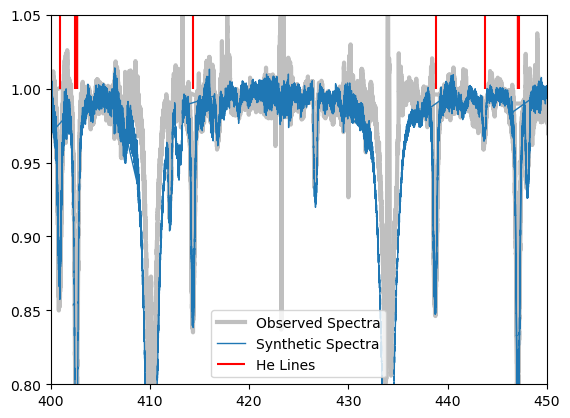

In [35]:
plt.plot(data.wl,data.specI,label='Observed Spectra',color='grey',alpha=0.5,linewidth=3)
plt.plot(synth.wl,synth.specI,label='Synthetic Spectra',color='C0',alpha=1,linewidth=1)

plt.vlines(mask[np.where((mask.iuse==1) & (mask.element==2.))].wl,1,1.05,label='He Lines',color='Red')
plt.legend()
plt.xlim(400,450)
plt.ylim(0.8,1.05)

In [10]:
from LSDpy import lsdpy
velS=-3*vsini
velE=3*vsini
velP=3.0
outfile_AFH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FH.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=fullfile_mask, outName=outfile_AFH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
AFH = pol.read_lsd(outfile_AFH)

outfile_AUH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UH.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=file_mask, outName=outfile_AUH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
AUH = pol.read_lsd(outfile_AUH)

outfile_AUO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UO.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile_AUO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
AUO=pol.read_lsd(outfile_AUO)

outfile_AFO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FO.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=fullfile_mask, outName=outfile_AFO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
AFO=pol.read_lsd(outfile_AFO)

Average observed spec velocity spacing: 1.806435 km/s
using a 341 point profile with 3.000000 km/s pixels
mean mask depth 0.088284 wl 505.117 Lande 1.202035 (from 954 lines)
mean mask norm weightI 0.441420 weightV 0.432688
I reduced chi2 39.6823 (chi2 4825370.77 constraints 121941 dof 341)
 Rescaling error bars by: 6.299391
V reduced chi2 1.1001 (chi2 133774.37 constraints 121941 dof 341)
 Rescaling error bars by: 1.048865
 removing profile continuum pol: -1.0733e-05 +/- 7.2999e-09 (avg err 8.5391e-05)
N1 reduced chi2 1.1088 (chi2 134826.31 constraints 121941 dof 341)
 Rescaling error bars by: 1.052981
 removing profile continuum pol: -1.1976e-05 +/- 7.3573e-09 (avg err 8.5726e-05)
line range estimate -231.0 138.0 km/s
V in line reduced chi^2 0.982134 (chi2 119.820347) 
 detect prob 0.461118 (fap 5.388823e-01)
 Non-detection V (fap 5.388823e-01)
 V outside line reduced chi^2 0.914541 (chi2 194.797334) 
 detect prob 0.190560 (fap 8.094396e-01)
N1 in line reduced chi^2 1.159149 (chi2 141

### He Only

In [11]:
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element>=3.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_HeOnly.mask'.format(path,star,ModelCode,vsini))



In [12]:
file_mask='{}02-Mask-calculations/MaskCleaning/AsifMaskSuperClean_tellClean/{}_clean_{}.mask'.format(path,star,1)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element>=3.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_HeOnly.mask'.format(path,star,star))




In [13]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

synthfile = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}.s'.format(path,star,star,ModelCode,vsini)
synth = pol.read_spectrum(synthfile)

fullfile_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_HeOnly.mask'.format(path,star,ModelCode,vsini)
mask = pol.read_mask(fname=fullfile_mask)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_HeOnly.mask'.format(path,star,star)
mask = pol.read_mask(fname=file_mask)



In [14]:
from LSDpy import lsdpy
velS=-3*vsini
velE=3*vsini
velP=3.0
outfile_HeFH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FH_HeOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=fullfile_mask, outName=outfile_HeFH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
HeFH = pol.read_lsd(outfile_HeFH)

outfile_HeUH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UH_HeOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=file_mask, outName=outfile_HeUH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
HeUH = pol.read_lsd(outfile_HeUH)

outfile_HeUO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UO_HeOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile_HeUO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
HeUO=pol.read_lsd(outfile_HeUO)

outfile_HeFO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FO_HeOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=fullfile_mask, outName=outfile_HeFO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
HeFO=pol.read_lsd(outfile_HeFO)

Average observed spec velocity spacing: 1.806435 km/s
using a 341 point profile with 3.000000 km/s pixels
mean mask depth 0.283500 wl 536.782 Lande 1.226262 (from 42 lines)
mean mask norm weightI 1.417500 weightV 1.316680
I reduced chi2 101.2189 (chi2 1532151.09 constraints 15478 dof 341)
 Rescaling error bars by: 10.060762
V reduced chi2 1.0944 (chi2 16565.97 constraints 15478 dof 341)
 Rescaling error bars by: 1.046137
 removing profile continuum pol: -2.4249e-06 +/- 2.4171e-08 (avg err 1.5530e-04)
N1 reduced chi2 1.1164 (chi2 16899.30 constraints 15478 dof 341)
 Rescaling error bars by: 1.056609
 removing profile continuum pol: -1.4219e-05 +/- 2.4658e-08 (avg err 1.5685e-04)
line range estimate -189.0 132.0 km/s
V in line reduced chi^2 1.092585 (chi2 116.906626) 
 detect prob 0.758852 (fap 2.411476e-01)
 Non-detection V (fap 2.411476e-01)
 V outside line reduced chi^2 0.957187 (chi2 218.238713) 
 detect prob 0.332701 (fap 6.672988e-01)
N1 in line reduced chi^2 0.992222 (chi2 106.167

### No He Only

In [15]:
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element<3.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_MetalsOnly.mask'.format(path,star,ModelCode,vsini))



In [16]:
file_mask='{}02-Mask-calculations/MaskCleaning/AsifMaskSuperClean_tellClean/{}_clean_{}.mask'.format(path,star,1)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element<3.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_MetalsOnly.mask'.format(path,star,star))




In [17]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

synthfile = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}.s'.format(path,star,star,ModelCode,vsini)
synth = pol.read_spectrum(synthfile)

fullfile_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_MetalsOnly.mask'.format(path,star,ModelCode,vsini)
mask = pol.read_mask(fname=fullfile_mask)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_MetalsOnly.mask'.format(path,star,star)
mask = pol.read_mask(fname=file_mask)



In [18]:
from LSDpy import lsdpy
velS=-3*vsini
velE=3*vsini
velP=3.0
outfile_MFH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FH_MetalsOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=fullfile_mask, outName=outfile_MFH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
MFH = pol.read_lsd(outfile_MFH)

outfile_MUH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UH_MetalsOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=file_mask, outName=outfile_MUH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
MUH = pol.read_lsd(outfile_MUH)

outfile_MUO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UO_MetalsOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile_MUO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
MUO=pol.read_lsd(outfile_MUO)

outfile_MFO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FO_MetalsOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=fullfile_mask, outName=outfile_MFO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
MFO=pol.read_lsd(outfile_MFO)

Average observed spec velocity spacing: 1.806435 km/s
using a 341 point profile with 3.000000 km/s pixels
mean mask depth 0.079294 wl 503.659 Lande 1.200919 (from 912 lines)
mean mask norm weightI 0.396469 weightV 0.391978
I reduced chi2 64.4075 (chi2 7680207.90 constraints 119585 dof 341)
 Rescaling error bars by: 8.025428
V reduced chi2 1.0994 (chi2 131101.18 constraints 119585 dof 341)
 Rescaling error bars by: 1.048540
 removing profile continuum pol: -1.4327e-05 +/- 1.0552e-08 (avg err 1.0267e-04)
N1 reduced chi2 1.1093 (chi2 132275.11 constraints 119585 dof 341)
 Rescaling error bars by: 1.053224
 removing profile continuum pol: -1.3600e-05 +/- 1.0647e-08 (avg err 1.0313e-04)
line range estimate -186.0 96.0 km/s
V in line reduced chi^2 0.869729 (chi2  81.754508) 
 detect prob 0.187829 (fap 8.121707e-01)
 Non-detection V (fap 8.121707e-01)
 V outside line reduced chi^2 0.875593 (chi2 211.017970) 
 detect prob 0.081345 (fap 9.186547e-01)
N1 in line reduced chi^2 1.188816 (chi2 111.

In [19]:
fullfile_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_MetalsOnly.mask'.format(path,star,ModelCode,vsini)
fullmask_metal = pol.read_mask(fname=fullfile_mask)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_MetalsOnly.mask'.format(path,star,star)
mask_metal = pol.read_mask(fname=file_mask)

fullfile_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_HeOnly.mask'.format(path,star,ModelCode,vsini)
fullmask_He = pol.read_mask(fname=fullfile_mask)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_HeOnly.mask'.format(path,star,star)
mask_He = pol.read_mask(fname=file_mask)




Text(0.5, 0, 'Line Depth')

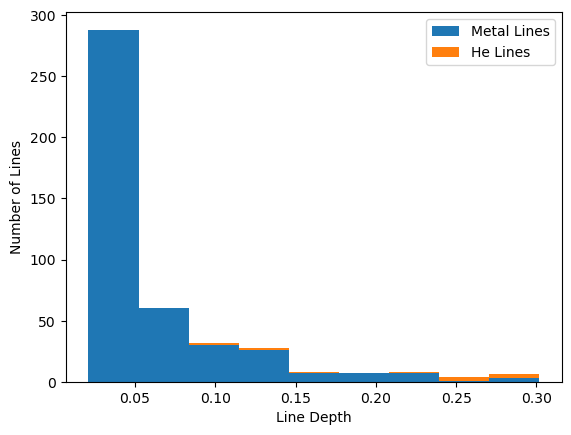

In [20]:

He_depth=mask_He.depth[np.where(mask_He.iuse==1)[0]]
metal_depth=mask_metal.depth[np.where(mask_metal.iuse==1)[0]]
binsm=np.arange(metal_depth.min(),metal_depth.max(),(He_depth.max()-He_depth.min())/10)
plt.hist([metal_depth,He_depth],bins=binsm,histtype='barstacked',label=['Metal Lines','He Lines'])
plt.legend()
plt.ylabel('Number of Lines')
plt.xlabel('Line Depth')



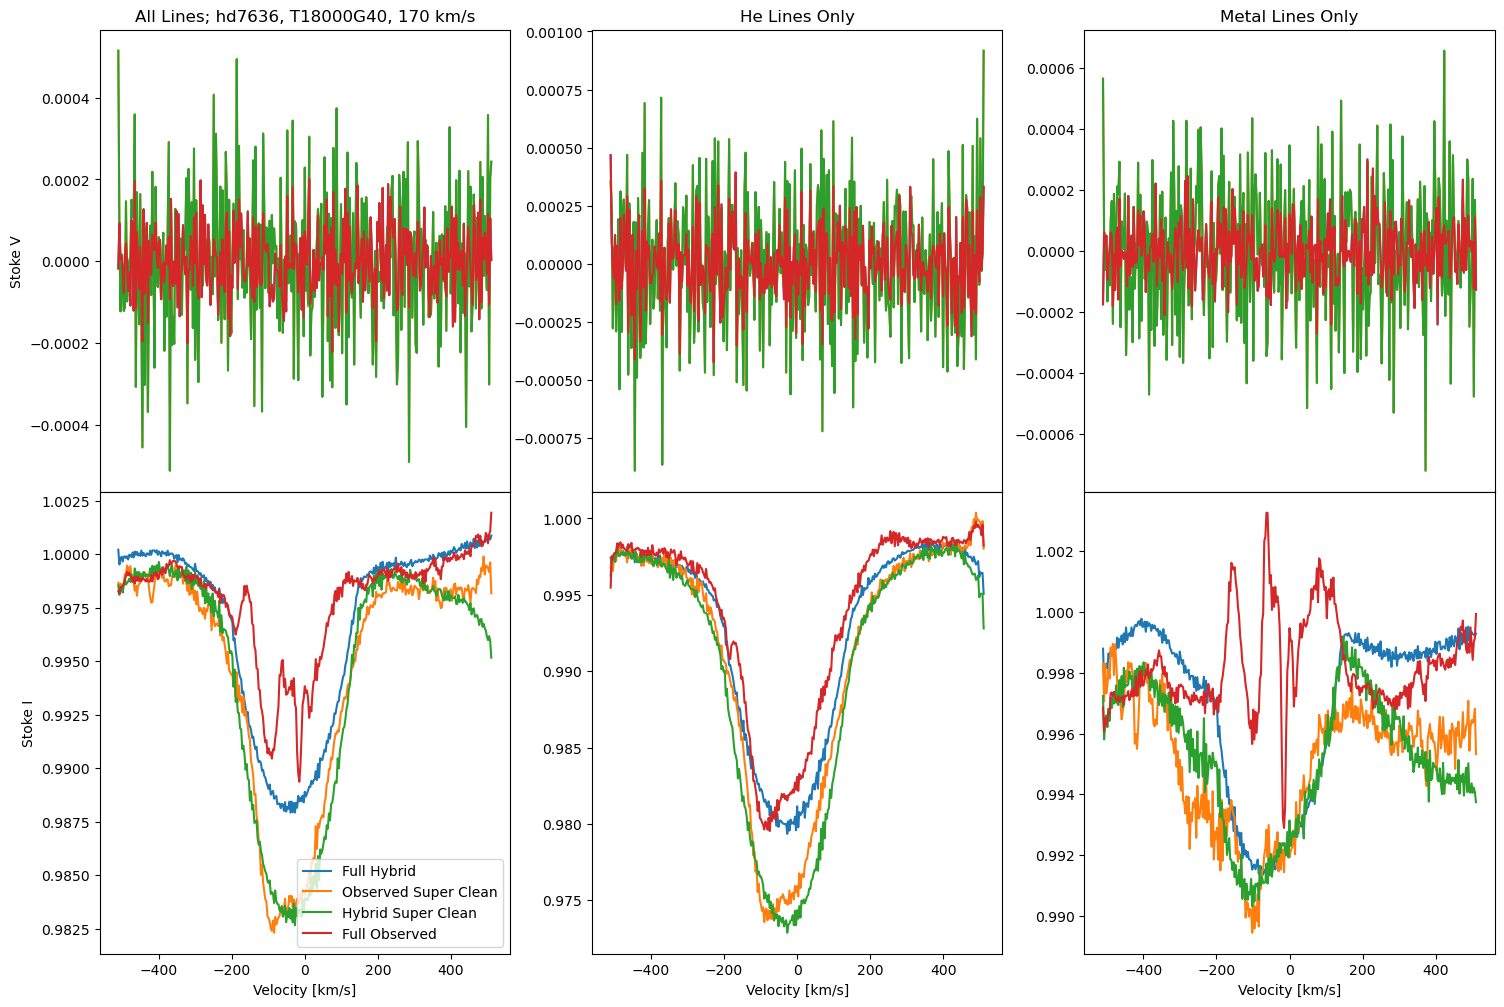

In [21]:
fig, ax = plt.subplots(2,3,sharex=True,figsize=(18,12))
ax[0,0].set_title('All Lines; {}, {}, {} km/s'.format(star,ModelCode,vsini))
ax[0,0].plot(AFH.vel,AFH.specV)
ax[0,0].plot(AUO.vel,AUO.specV)
ax[0,0].plot(AUH.vel,AUH.specV)
ax[0,0].plot(AFO.vel,AFO.specV)
ax[1,0].plot(AFH.vel,AFH.specI,label='Full Hybrid'.format(ModelCode))
ax[1,0].plot(AUO.vel,AUO.specI,label='Observed Super Clean'.format(ModelCode))
ax[1,0].plot(AUH.vel,AUH.specI,label='Hybrid Super Clean'.format(ModelCode))
ax[1,0].plot(AFO.vel,AFO.specI,label='Full Observed'.format(ModelCode))

ax[0,0].set_ylabel('Stoke V')
ax[1,0].set_ylabel('Stoke I')
ax[1,0].set_xlabel('Velocity [km/s]')
ax[1,0].legend()
#ax.set_title('Original')

ax[0,1].set_title('He Lines Only')
ax[0,1].plot(HeFH.vel,HeFH.specV)
ax[0,1].plot(HeUO.vel,HeUO.specV)
ax[0,1].plot(HeUH.vel,HeUH.specV)
ax[0,1].plot(HeFO.vel,HeFO.specV)
ax[1,1].plot(HeFH.vel,HeFH.specI,label='Full Hybrid'.format(ModelCode))
ax[1,1].plot(HeUO.vel,HeUO.specI,label='Observed Super Clean'.format(ModelCode))
ax[1,1].plot(HeUH.vel,HeUH.specI,label='Hybrid Super Clean'.format(ModelCode))
ax[1,1].plot(HeFO.vel,HeFO.specI,label='Full Observed'.format(ModelCode))

ax[1,1].set_xlabel('Velocity [km/s]')
#ax.set_title('Original')

ax[0,2].set_title('Metal Lines Only')
ax[0,2].plot(MFH.vel,MFH.specV)
ax[0,2].plot(MUO.vel,MUO.specV)
ax[0,2].plot(MUH.vel,MUH.specV)
ax[0,2].plot(MFO.vel,MFO.specV)
ax[1,2].plot(MFH.vel,MFH.specI,label='Full Hybrid'.format(ModelCode))
ax[1,2].plot(MUO.vel,MUO.specI,label='Observed Super Clean'.format(ModelCode))
ax[1,2].plot(MUH.vel,MUH.specI,label='Hybrid Super Clean'.format(ModelCode))
ax[1,2].plot(MFO.vel,MFO.specI,label='Full Observed'.format(ModelCode))

ax[1,2].set_xlabel('Velocity [km/s]')
#ax.set_title('Original')

plt.subplots_adjust(wspace=0.2, hspace=0)

## HD 20336

In [56]:
star='hd20336'
vsini=320
ModelCode='T19000G40'
vradCorrected=-30 *u.km/u.s

In [57]:
import copy
# reading the observed spectrum
file_obs = '{}00-InputMaterial/NormalizedSpectra/{}_{}.s'.format(path,star, 1)
data_obs = pol.read_spectrum(file_obs)
# splitting the observed spectrum by order
list_order = split_order(data_obs)


file_mod = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}.dsk'.format(path,star,ModelCode,vsini)
mod_wave, mod_flux = read_disk(file_mod)
# shifting the model spectrum for its radial velocity
# (note the rshift function asks for numpy unit quantities)

mod_wave_shift = rshift(mod_wave*u.nm, vradCorrected)

for order in list_order:

  # interpolate the shifted model onto the order grid
  mod_flux_interp = np.interp(order.wl, mod_wave_shift, mod_flux)

  # drawing n random elements with a mean of zero and a stdev of 1.0
  # scaling to a sigma corresponding to the error bar
  noise = np.random.standard_normal(order.wl.size)*order.specSig
  mod_flux_interp = mod_flux_interp + noise
  # replacing the flux array in the order
  order.specI = copy.deepcopy(mod_flux_interp)

# putting the orders back together
new = splice_order(list_order)

### writting back the file in the proper folder. 
## need to look for a write function for .s, maybe in Colin's 
## normalization code?

new.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}.s'.format(path,star,star,ModelCode,vsini))

37 orders


### All

In [58]:
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)
#mask.iuse[np.where([mask.element==14.01,mask.element==14.02,mask.element==14.03,mask.element==16.01,mask.element==16.02])[1]]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}.mask'.format(path,star,ModelCode,vsini))



In [59]:
file_mask='{}02-Mask-calculations/MaskCleaning/AsifMaskSuperClean_tellClean/{}_clean_{}.mask'.format(path,star,1)
mask = pol.read_mask(fname=file_mask)
#mask.iuse[np.where([mask.element==14.01,mask.element==14.02,mask.element==14.03,mask.element==16.01,mask.element==16.02])[1]]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated.mask'.format(path,star,star))




In [60]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

synthfile = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}.s'.format(path,star,star,ModelCode,vsini)
synth = pol.read_spectrum(synthfile)

fullfile_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}.mask'.format(path,star,ModelCode,vsini)
mask = pol.read_mask(fname=fullfile_mask)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated.mask'.format(path,star,star)
mask = pol.read_mask(fname=file_mask)



(0.4, 1.05)

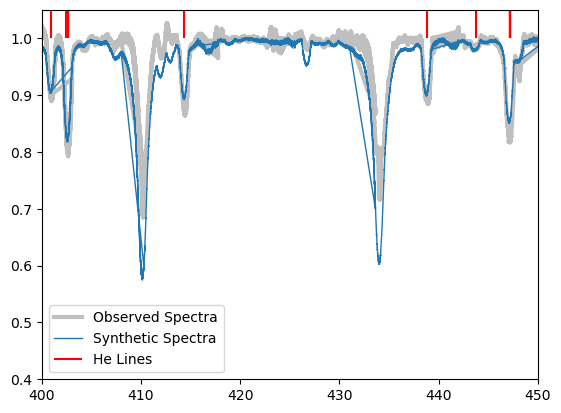

In [61]:
plt.plot(data.wl,data.specI,label='Observed Spectra',color='grey',alpha=0.5,linewidth=3)
plt.plot(synth.wl,synth.specI,label='Synthetic Spectra',color='C0',alpha=1,linewidth=1)

plt.vlines(mask[np.where((mask.iuse==1) & (mask.element==2.))].wl,1,1.05,label='He Lines',color='Red')
plt.legend()
plt.xlim(400,450)
plt.ylim(0.4,1.05)

In [62]:
from LSDpy import lsdpy
velS=-3*vsini
velE=3*vsini
velP=3.0
outfile_AFH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FH.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=fullfile_mask, outName=outfile_AFH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
AFH = pol.read_lsd(outfile_AFH)

outfile_AUH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UH.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=file_mask, outName=outfile_AUH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
AUH = pol.read_lsd(outfile_AUH)

outfile_AUO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UO.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile_AUO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
AUO=pol.read_lsd(outfile_AUO)

outfile_AFO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FO.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=fullfile_mask, outName=outfile_AFO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
AFO=pol.read_lsd(outfile_AFO)

Average observed spec velocity spacing: 1.779756 km/s
using a 641 point profile with 3.000000 km/s pixels
mean mask depth 0.090680 wl 502.343 Lande 1.207214 (from 956 lines)
mean mask norm weightI 0.453400 weightV 0.443729
I reduced chi2 1005.7599 (chi2 137685515.83 constraints 137538 dof 641)
 Rescaling error bars by: 31.713718
V reduced chi2 0.9869 (chi2 135106.40 constraints 137538 dof 641)
 Not rescaling error bars (scale 0.993439)
 removing profile continuum pol: -3.2943e-07 +/- 1.6430e-09 (avg err 4.0519e-05)
N1 reduced chi2 1.0052 (chi2 137608.72 constraints 137538 dof 641)
 Rescaling error bars by: 1.002596
 removing profile continuum pol: -5.9616e-07 +/- 1.6515e-09 (avg err 4.0624e-05)
line range estimate -120.0 66.0 km/s
V in line reduced chi^2 0.820573 (chi2  48.413828) 
 detect prob 0.164182 (fap 8.358180e-01)
 Non-detection V (fap 8.358180e-01)
 V outside line reduced chi^2 0.924248 (chi2 532.366944) 
 detect prob 0.096842 (fap 9.031577e-01)
N1 in line reduced chi^2 0.8663

### He Only

In [63]:
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element>=3.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_HeOnly.mask'.format(path,star,ModelCode,vsini))



In [64]:
file_mask='{}02-Mask-calculations/MaskCleaning/AsifMaskSuperClean_tellClean/{}_clean_{}.mask'.format(path,star,1)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element>=3.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_HeOnly.mask'.format(path,star,star))




In [65]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

synthfile = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}.s'.format(path,star,star,ModelCode,vsini)
synth = pol.read_spectrum(synthfile)

fullfile_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_HeOnly.mask'.format(path,star,ModelCode,vsini)
mask = pol.read_mask(fname=fullfile_mask)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_HeOnly.mask'.format(path,star,star)
mask = pol.read_mask(fname=file_mask)



In [66]:
from LSDpy import lsdpy
velS=-3*vsini
velE=3*vsini
velP=3.0
outfile_HeFH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FH_HeOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=fullfile_mask, outName=outfile_HeFH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
HeFH = pol.read_lsd(outfile_HeFH)

outfile_HeUH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UH_HeOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=file_mask, outName=outfile_HeUH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
HeUH = pol.read_lsd(outfile_HeUH)

outfile_HeUO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UO_HeOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile_HeUO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
HeUO=pol.read_lsd(outfile_HeUO)

outfile_HeFO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FO_HeOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=fullfile_mask, outName=outfile_HeFO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
HeFO=pol.read_lsd(outfile_HeFO)

Average observed spec velocity spacing: 1.779756 km/s
using a 641 point profile with 3.000000 km/s pixels
mean mask depth 0.282356 wl 552.747 Lande 1.244511 (from 45 lines)
mean mask norm weightI 1.411778 weightV 1.333034
I reduced chi2 397.0266 (chi2 9815689.18 constraints 25364 dof 641)
 Rescaling error bars by: 19.925527
V reduced chi2 0.9961 (chi2 24627.57 constraints 25364 dof 641)
 Not rescaling error bars (scale 0.998068)
 removing profile continuum pol: -1.4855e-06 +/- 4.4587e-09 (avg err 6.6726e-05)
N1 reduced chi2 1.0162 (chi2 25123.40 constraints 25364 dof 641)
 Rescaling error bars by: 1.008065
 removing profile continuum pol: -2.4988e-06 +/- 4.5309e-09 (avg err 6.7264e-05)
line range estimate -297.0 231.0 km/s
V in line reduced chi^2 0.920380 (chi2 161.066463) 
 detect prob 0.232808 (fap 7.671920e-01)
 Non-detection V (fap 7.671920e-01)
 V outside line reduced chi^2 1.017746 (chi2 468.163067) 
 detect prob 0.613901 (fap 3.860986e-01)
N1 in line reduced chi^2 1.029542 (chi2

### No He Only

In [67]:
file_mask='{}02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(path,ModelCode)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element<3.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_MetalsOnly.mask'.format(path,star,ModelCode,vsini))



In [68]:
file_mask='{}02-Mask-calculations/MaskCleaning/AsifMaskSuperClean_tellClean/{}_clean_{}.mask'.format(path,star,1)
mask = pol.read_mask(fname=file_mask)
mask.iuse[np.where(mask.element<3.)]=0
mask.save('{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_MetalsOnly.mask'.format(path,star,star))




In [69]:
file = '{}00-InputMaterial/NormalizedSpectra/{}_1.s'.format(path,star)
data = pol.read_spectrum(file)

synthfile = '{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}.s'.format(path,star,star,ModelCode,vsini)
synth = pol.read_spectrum(synthfile)

fullfile_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_MetalsOnly.mask'.format(path,star,ModelCode,vsini)
mask = pol.read_mask(fname=fullfile_mask)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_MetalsOnly.mask'.format(path,star,star)
mask = pol.read_mask(fname=file_mask)



In [70]:
from LSDpy import lsdpy
velS=-3*vsini
velE=3*vsini
velP=3.0
outfile_MFH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FH_MetalsOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=fullfile_mask, outName=outfile_MFH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
MFH = pol.read_lsd(outfile_MFH)

outfile_MUH='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UH_MetalsOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=synthfile, mask=file_mask, outName=outfile_MUH, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
MUH = pol.read_lsd(outfile_MUH)

outfile_MUO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_UO_MetalsOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=file_mask, outName=outfile_MUO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
MUO=pol.read_lsd(outfile_MUO)

outfile_MFO='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_{}_FO_MetalsOnly.lsd'.format(path,star,star,ModelCode,vsini)
toto = lsdpy.main(observation=file, mask=fullfile_mask, outName=outfile_MFO, 
        velStart=velS, velEnd=velE, velPixel=velP, 
        normDepth=0.2, normLande=1.2, normWave=500.0,
        removeContPol=1, trimMask=0, sigmaClipIter=0, sigmaClip=500, 
        interpMode=1, fSaveModelS=0, outModelName='',
        fLSDPlotImg=0, fSavePlotImg=0, outPlotImgName='')
MFO=pol.read_lsd(outfile_MFO)

Average observed spec velocity spacing: 1.779756 km/s
using a 641 point profile with 3.000000 km/s pixels
mean mask depth 0.081212 wl 499.853 Lande 1.205372 (from 911 lines)
mean mask norm weightI 0.406059 weightV 0.399801
I reduced chi2 1099.4758 (chi2 147346244.42 constraints 134656 dof 641)
 Rescaling error bars by: 33.158344
V reduced chi2 0.9849 (chi2 131984.74 constraints 134656 dof 641)
 Not rescaling error bars (scale 0.992396)
 removing profile continuum pol: -3.1047e-07 +/- 2.6204e-09 (avg err 5.1173e-05)
N1 reduced chi2 1.0027 (chi2 134381.03 constraints 134656 dof 641)
 Rescaling error bars by: 1.001365
 removing profile continuum pol: -4.4255e-07 +/- 2.6276e-09 (avg err 5.1243e-05)
ERROR: could not find line range!  (using full profile)
V in line reduced chi^2 0.872344 (chi2 554.810576) 
 detect prob 0.009080 (fap 9.909197e-01)
 Non-detection V (fap 9.909197e-01)
 V outside line reduced chi^2 0.872344 (chi2 554.810576) 
 detect prob 0.009080 (fap 9.909197e-01)
N1 in line r

In [71]:
fullfile_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_MetalsOnly.mask'.format(path,star,ModelCode,vsini)
fullmask_metal = pol.read_mask(fname=fullfile_mask)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_MetalsOnly.mask'.format(path,star,star)
mask_metal = pol.read_mask(fname=file_mask)

fullfile_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_{}_HeOnly.mask'.format(path,star,ModelCode,vsini)
fullmask_He = pol.read_mask(fname=fullfile_mask)

file_mask='{}10-Spectra-Data-vs-hybrid-plots and Halpha and TESS/SpectraCorrections/{}/{}_uncontaminated_HeOnly.mask'.format(path,star,star)
mask_He = pol.read_mask(fname=file_mask)




Text(0.5, 0, 'Line Depth')

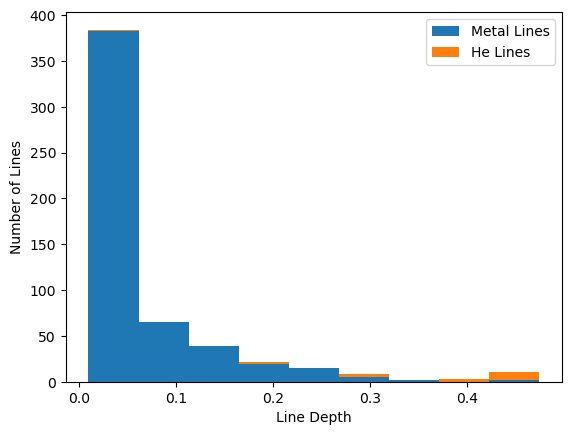

In [72]:

He_depth=mask_He.depth[np.where(mask_He.iuse==1)[0]]
metal_depth=mask_metal.depth[np.where(mask_metal.iuse==1)[0]]
binsm=np.arange(metal_depth.min(),metal_depth.max(),(He_depth.max()-He_depth.min())/10)
plt.hist([metal_depth,He_depth],bins=binsm,histtype='barstacked',label=['Metal Lines','He Lines'])
plt.legend()
plt.ylabel('Number of Lines')
plt.xlabel('Line Depth')



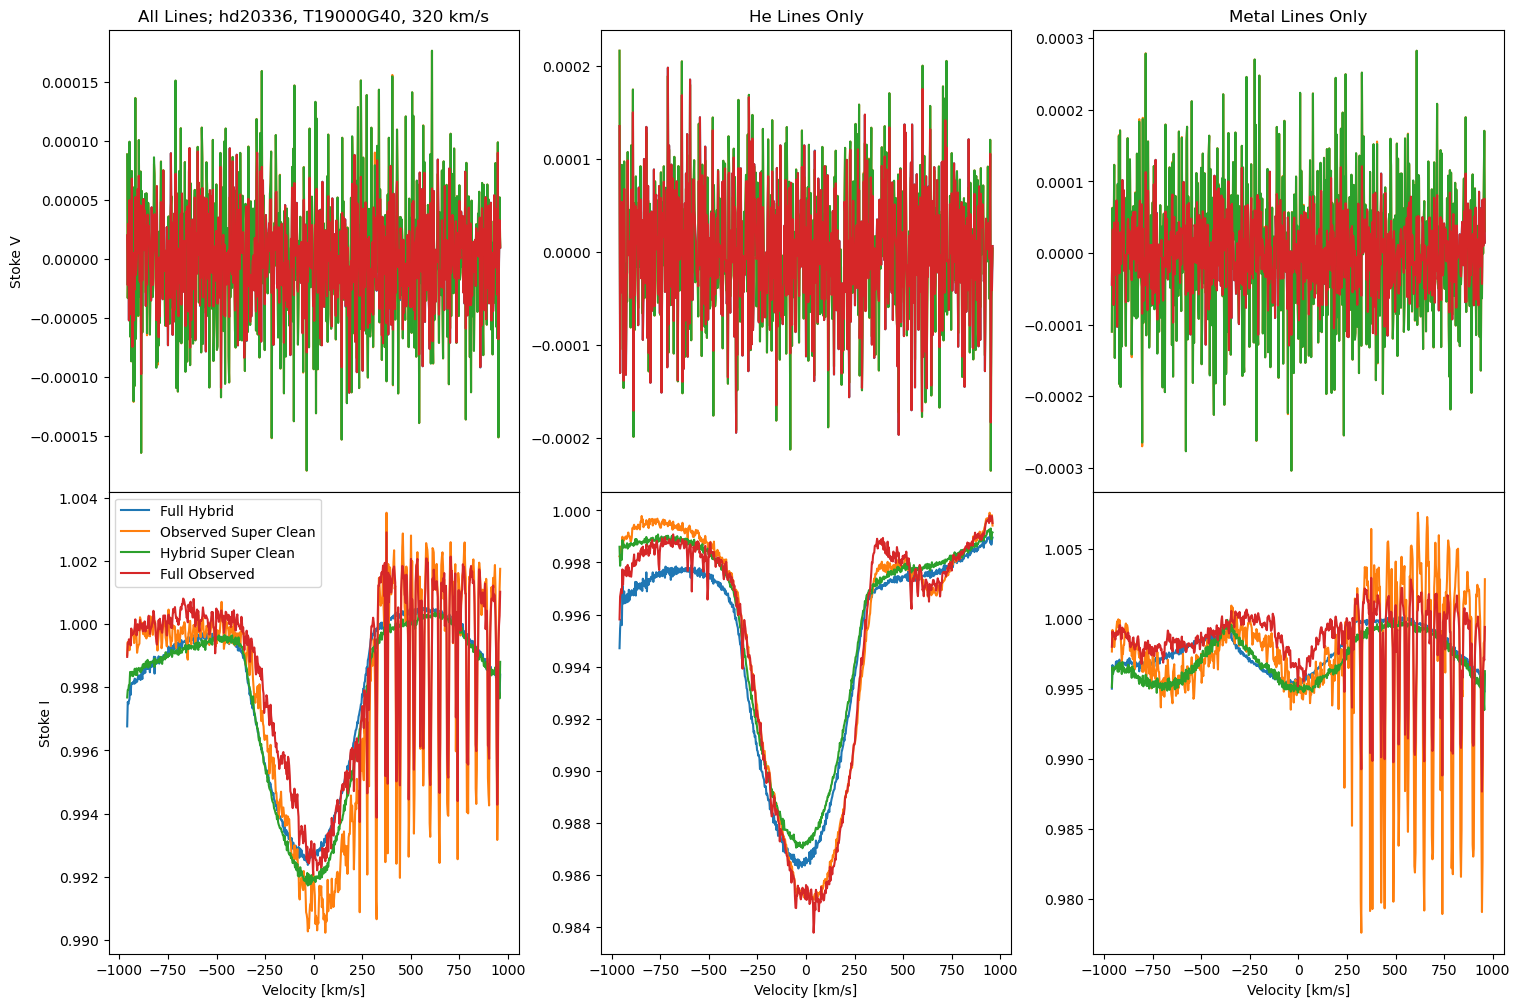

In [73]:
fig, ax = plt.subplots(2,3,sharex=True,figsize=(18,12))
ax[0,0].set_title('All Lines; {}, {}, {} km/s'.format(star,ModelCode,vsini))
ax[0,0].plot(AFH.vel,AFH.specV)
ax[0,0].plot(AUO.vel,AUO.specV)
ax[0,0].plot(AUH.vel,AUH.specV)
ax[0,0].plot(AFO.vel,AFO.specV)
ax[1,0].plot(AFH.vel,AFH.specI,label='Full Hybrid'.format(ModelCode))
ax[1,0].plot(AUO.vel,AUO.specI,label='Observed Super Clean'.format(ModelCode))
ax[1,0].plot(AUH.vel,AUH.specI,label='Hybrid Super Clean'.format(ModelCode))
ax[1,0].plot(AFO.vel,AFO.specI,label='Full Observed'.format(ModelCode))

ax[0,0].set_ylabel('Stoke V')
ax[1,0].set_ylabel('Stoke I')
ax[1,0].set_xlabel('Velocity [km/s]')
ax[1,0].legend()
#ax.set_title('Original')

ax[0,1].set_title('He Lines Only')
ax[0,1].plot(HeFH.vel,HeFH.specV)
ax[0,1].plot(HeUO.vel,HeUO.specV)
ax[0,1].plot(HeUH.vel,HeUH.specV)
ax[0,1].plot(HeFO.vel,HeFO.specV)
ax[1,1].plot(HeFH.vel,HeFH.specI,label='Full Hybrid'.format(ModelCode))
ax[1,1].plot(HeUO.vel,HeUO.specI,label='Observed Super Clean'.format(ModelCode))
ax[1,1].plot(HeUH.vel,HeUH.specI,label='Hybrid Super Clean'.format(ModelCode))
ax[1,1].plot(HeFO.vel,HeFO.specI,label='Full Observed'.format(ModelCode))

ax[1,1].set_xlabel('Velocity [km/s]')
#ax.set_title('Original')

ax[0,2].set_title('Metal Lines Only')
ax[0,2].plot(MFH.vel,MFH.specV)
ax[0,2].plot(MUO.vel,MUO.specV)
ax[0,2].plot(MUH.vel,MUH.specV)
ax[0,2].plot(MFO.vel,MFO.specV)
ax[1,2].plot(MFH.vel,MFH.specI,label='Full Hybrid'.format(ModelCode))
ax[1,2].plot(MUO.vel,MUO.specI,label='Observed Super Clean'.format(ModelCode))
ax[1,2].plot(MUH.vel,MUH.specI,label='Hybrid Super Clean'.format(ModelCode))
ax[1,2].plot(MFO.vel,MFO.specI,label='Full Observed'.format(ModelCode))

ax[1,2].set_xlabel('Velocity [km/s]')
#ax.set_title('Original')

plt.subplots_adjust(wspace=0.2, hspace=0)